In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import Predictive

from utils import *

/tmp/ipykernel_6197/804203489.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/sandoar/miniconda3/envs/model/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We define the MultiPlayer model in the code below. First we would like to confirm that this model behaves like our 2 Player model. To test this we generate dummy data for six players in a round-robin tournament structure.
A round-robin tournament means that every player will play against every other player exactly once. To make it easy to check the results, the outcome of the games will be determined by the index of the players. The player with the higher index will always win. This means that the player with index 0 will lose all games, the player with index 1 will lose all games except against player 0, and so on.

In [3]:
def ModelMultiPlayer(game_info, obs=None):
    """
    Inputs:
        game_info: A dictionary containing the following keys:
            coach1_ids: A 1D tensor of length "num_games". The i-th element represents the id of the coach for coach 1 in the i-th game.
            coach2_ids: A 1D tensor of length "num_games". The i-th element represents the id of the coach for coach 2 in the i-th game.
            num_coaches: An integer representing the number of coaches in the data.
        obs: obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.

    Output: A 1D tensor of the same length as "obs". Represents a sample from difference in performance between the two coaches.
    """

    # Extract the data
    ids1 = game_info['coach1_ids']
    ids2 = game_info['coach2_ids']
    num_coaches = game_info['num_coaches']

    # set hyperparameters
    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    # Sample the performance difference for each match
    with pyro.plate('matches', obs.shape[0]):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [4]:
num_coaches = 6
num_games = 15

# round robin structure generated by chatgpt
id1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]
id2 = [2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]

id1 = torch.tensor(id1).long()
id1 = id1 - 1
id2 = torch.tensor(id2).long()
id2 = id2 - 1

obs = []
for i in range(num_games):
    if id1[i] < id2[i]:
        obs.append(-1)
    else:
        obs.append(1)

obs = torch.tensor(obs)

game_info = {'coach1_ids': id1, 'coach2_ids': id2, 'num_coaches': num_coaches}

In [5]:
guide = AutoNormal(ModelMultiPlayer)

losses = run_inference(ModelMultiPlayer, guide, game_info, obs)

Loss = 47.527958: 100%|██████████| 2000/2000 [00:25<00:00, 77.48it/s] 


In [6]:
predictive = Predictive(ModelMultiPlayer, guide=AutoNormal(ModelMultiPlayer), num_samples=2000)

samples = predictive(game_info, obs)

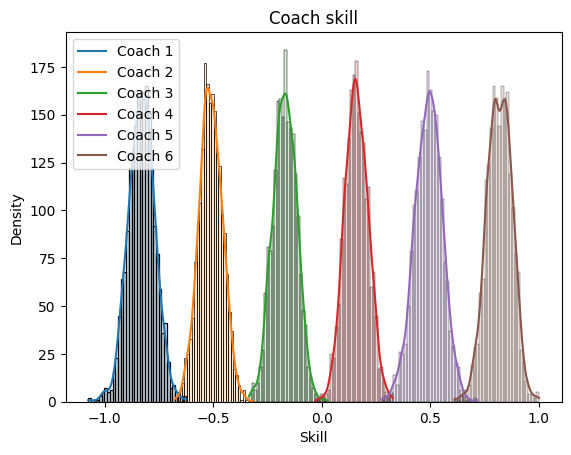

In [7]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


We see that the posterior distributions of the Multi Player model behave the same way as the 2 player model. Coach 6 who has won all games has the highest posterior mean, while coach 1 who has lost all games has the lowest posterior mean.\
Also not the symmetry of the posterior distributions. This is important since we want to compare the skill levels of players who have not yet played together.

Now we want to train the Multi Player model on the real training data and afterwards evaluate the model on the test data.\
For this part, we need to further set up the data for this model. We need to set an index for each coach and be able to match it to their ID from the data frame. Then for each coach we calculate the number of games they have played and their respective win rates. This will be used to sort the coaches, so we can easily fetch relevant data about them.

In [8]:
# read and format data
df = pd.read_csv('../data/X_train.csv')

# make a list of unique coaches
coaches1 = df['team1_coach_id']
coaches2 = df['team2_coach_id']
unique_coaches = pd.concat([coaches1, coaches2]).unique()
unique_coaches.sort()

num_coaches = len(unique_coaches)

# prepare some vectors
coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)
coach_num_wins = np.zeros(num_coaches)
coach_num_draws = np.zeros(num_coaches)

# calculate winrates for each coach
for id, coach_id in enumerate(unique_coaches):
    coach_num_matches[id]  = len(df[(df['team1_coach_id'] == coach_id) | (df['team2_coach_id'] == coach_id)])
    coach_num_wins[id] = df[(df['team1_coach_id'] == coach_id) & (df['team1_win'] == 1)].shape[0] + df[(df['team2_coach_id'] == coach_id) & (df['team2_win'] == 1)].shape[0]
    coach_num_draws[id] = df[(df['team1_coach_id'] == coach_id) & (df['team1_win'] == 0)].shape[0] + df[(df['team2_coach_id'] == coach_id) & (df['team2_win'] == 0)].shape[0]
    coach_winrates[id] = (coach_num_wins[id] + 0.5 * coach_num_draws[id]) / coach_num_matches[id]

# sort the coaches by winrate 
indices = np.lexsort((unique_coaches, coach_winrates, coach_num_matches))
sorted_coaches = unique_coaches[indices[::-1]]
sorted_winrates = coach_winrates[indices[::-1]]
sorted_num_matches = coach_num_matches[indices[::-1]]

# make a dictionary for the coaches matching index and coach_id
coach_dict = {coach: i for i, coach in enumerate(sorted_coaches)}

# make variables for the model sorted by winrate
id1 = torch.tensor(coaches1.map(coach_dict).values).long()
id2 = torch.tensor(coaches2.map(coach_dict).values).long()
obs = torch.tensor(df['team1_win'].values)

# set the game info
game_info = {'coach1_ids': id1, 'coach2_ids': id2, 'num_coaches': num_coaches}

Now we can train the model on the training data.

In [9]:
guide = AutoNormal(ModelMultiPlayer)

losses = run_inference(ModelMultiPlayer, guide, game_info, obs)

Loss = 454640.343018: 100%|██████████| 2000/2000 [01:26<00:00, 23.13it/s]


Before evaluating the model on the test data, we need to set up the data in the same way as we did for the training data.

In [12]:
# read and format data
df_test = pd.read_csv('../data/X_test.csv')

# make a list of unique coaches from the test set
coaches1_test = df_test['team1_coach_id']
coaches2_test = df_test['team2_coach_id']
unique_coaches_test = pd.concat([coaches1_test, coaches2_test]).unique()
unique_coaches_test.sort()

# make variables for the model sorted by winrate
id1_test = torch.tensor(coaches1_test.map(coach_dict).values).long()
id2_test = torch.tensor(coaches2_test.map(coach_dict).values).long()
obs_test = torch.tensor(df_test['team1_win'].values)

# set the game info
game_info_test = {'coach1_ids': id1_test, 'coach2_ids': id2_test, 'num_coaches': num_coaches}

In [ ]:
predictive = Predictive(ModelMultiPlayer, guide=AutoNormal(ModelMultiPlayer), num_samples=2000)

samples = predictive(game_info, obs)